In [2]:
import numpy as np
from numpy.fft import fft2, ifft2
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import measure

# OCR - Optical Character Recognition

Spis treści:

SZERYFOWE I NIE SZERYFOWE -> porównaj

# Założenia

- Tekst skłąda się z małych liter alfabetu łacińskiego oraz cyfr.
- Na obrazie występuje jeden typ i rozmiar czcionki.
- Występują znaki przestankowe: .,!?
- Tekst składa się z wielu linii.
- Tekst może być obrócony.
- Program pownien zwracać tekst wraz ze znakami białymi i znakami nowej linii.
- Program powinien zliczać liczbę wystąpień każdego znaku.

TODO:
- może raportować % poprawności dla predefiniowanych testów
- operacja splotu i dft
- redukcja szumu

BREAK

# Wczytywanie obrazu

Obraz wczytuję za pomocą biblioteki PIL i konwertuję go na skalę szarości

In [3]:
def read_image(filepath):
    return ImageOps.invert(Image.open(filepath).convert('L'))

# Wczytywanie czcionek

Do mojego programu przygotowałem dwa zestawy czcionek: 
- szeryfową (serif)
- nie szeryfową (sans-serif)  

Każdy zestaw zawiera 26 liter alfabetu łacińskiego, 4 znaki przestankowe, 10 cyfr oraz obraz wszystkich znaków w jednym pliku.  
Wczytuję je z plików .png, konwertuję na skalę szarości i zapisuję w tablicy numpy za pomocą powyżej zdefiniowanej funkcji.

In [4]:
def read_fonts():
    fonts = {font: {char[:-4]: read_image(f'./fonts/{font}/{char}') for char in os.listdir(f'./fonts/{font}')} for font in os.listdir('fonts')}
    for _, font in fonts.items():
        font['!'] = font['exclamation-mark']
        font['?'] = font['question-mark']
        font['.'] = font['dot']
        font[','] = font['comma']
        del font['exclamation-mark']
        del font['question-mark']
        del font['dot']
        del font['comma']
    return fonts

# Dodanie wszystkich znaków do obrazu 

Aby mieć pewność, że znak został rozpoznany, dodaję do obrazu wszystkie wzorce znaków z wybranego zestawu czcionek, które będą porównywane z obrazem wejściowym. Dzięki temu dodane wzorce powinny mieć największe wartości korelacji, właśnie z tą wartością będę porównywał obraz wejściowy.

In [5]:
def add_char_patterns(image, font):
    patterns = font['all']
    result = Image.new('L', (max(image.width, patterns.width), image.height + patterns.height), 0)
    result.paste(image, (0, 0))
    result.paste(patterns, (0, image.height))
    return result

# Korelacja

In [6]:
def correlation(image, sample):
    return np.real(ifft2(np.multiply(fft2(np.array(image)), fft2(np.rot90(sample, 2), np.array(image).shape))))

# Kolejność wykrywania znaków

Aby zwiększyć skuteczność wykrywania znaków, zacznę od największych znaków, a skończę na najmniejszych. Dzięki temu, jeśli znak jest zbyt mały, to nie będzie on wykrywany jako inny.  
Ponadto trzeba zwrócić uwagę na litery zawierające się w innych literach, np. 'c' w 'e'.  
Kolejnym kryterium będzie częstość występowania znaków, to znaczy, że znaki występujące częściej będą wykrywane wcześniej np. 'x' jest rzadko używane, więc będzie wykrywane póxniej niż 'y'.

/tmp/ipykernel_1435147/3060576480.py:2: RuntimeWarning: divide by zero encountered in log
  heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]


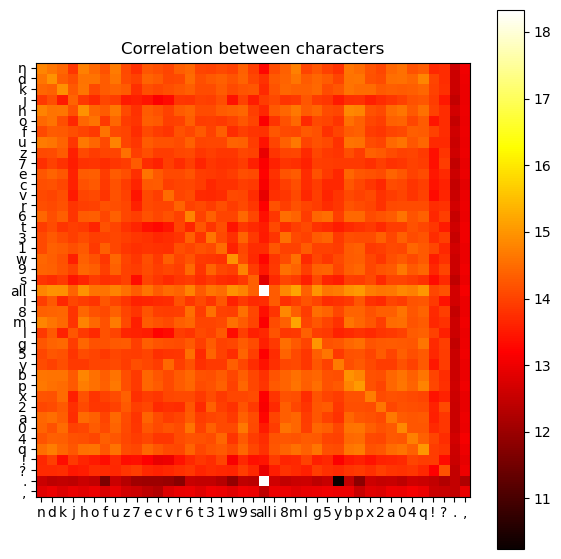

In [7]:
def correlation_heatmap(font):
    heatmap = [[np.log(correlation(font[char1], font[char2]).max()) for char2 in font] for char1 in font]
    plt.figure(figsize=(7, 7))
    plt.yticks(range(len(font)), font.keys())
    plt.xticks(range(len(font)), font.keys())
    plt.title('Correlation between characters')
    plt.colorbar(plt.imshow(heatmap, cmap='hot'))
    plt.show()

correlation_heatmap(read_fonts()['serif'])

In [11]:
def get_char_order(font, confidence=0.9, ratio=2, show=False):
    counter_dict = {}
    fig, ax = plt.subplots(len(font), 1, figsize=(font['all'].size[0]/ratio, font['all'].size[1]/ratio * len(font)))
    for i, char in enumerate(font):
        img_cor = correlation(font['all'], font[char])
        img_cor[img_cor<np.max(img_cor)*confidence] = 0.
        for i, j in np.argwhere(img_cor!=0.):
            ax[i].add_patch(patches.Rectangle((j,i), -font[char].size[0], -font[char].size[1], edgecolor='r', facecolor='none'))
        counter_dict[char] = len(measure.find_contours(img_cor, confidence*np.max(img_cor)))
        ax[i].imshow(img_cor, cmap='hot')
        ax[i].set_title(f'{char}-{counter_dict[char]}')

    plt.show()
    return counter_dict
    # subjective order
    # return ['a', 'b', 'p', 'd', 'g', 'e', 'f', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'c', 'q', 'r', 's', 't', 'u', 'y', 'w', 'z', 'v', 'x',
    #         '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    #         '0', '?', '!', ',', '.']

print(get_char_order(read_fonts()['serif'], show=True))

KeyboardInterrupt: 

# 

---